In [1]:
import argparse, os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorboard
import keras
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam,Nadam
from keras.utils import multi_gpu_model
from keras.applications import DenseNet201 #ResNet152V2,ResNet152V2#NASNetLarge InceptionResNetV2, DenseNet201,ResNet152V2 #ResNet50 , VGG19 , ,
from keras.layers import Dense, Dropout, Flatten, AveragePooling2D, BatchNormalization,LeakyReLU
from keras.applications.densenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

Using TensorFlow backend.


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('val_acc')>.850):
                print("\nReached 99.0% accuracy so cancelling training!")
                self.model.stop_training = True
callbacks = myCallback()


In [ ]:
!pwd

In [2]:
epochs     = 20
lr         = .0001
model_dir  = "./"
train_dir   ='/home/ec2-user/SageMaker/Image_Analytics/Data/train'
validation_dir = '/home/ec2-user/SageMaker/Image_Analytics/Data/val'
test_dir = '/home/ec2-user/SageMaker/Image_Analytics/Data/test'
num_classes = 2
image_resize = 224
batch_size = 16 

In [3]:
train_datagen = ImageDataGenerator(
                                       rescale = 1./255,
                                       featurewise_center=True, 
                                       samplewise_center=True,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       rotation_range = 40,
                                       horizontal_flip=True,
                                       vertical_flip = True,
                                       shear_range = 0.2,
                                       featurewise_std_normalization = True,
                                       zoom_range=0.2,
                                       fill_mode='nearest',
                                       samplewise_std_normalization = True,
                                       zca_epsilon=1e-06

                                            ) #change this if u want to reduce or increase more dataset for training images
    

In [4]:
valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True,
                                   shear_range = 0.2) #let 's have this for 2-4 only



In [5]:
test_datagen = ImageDataGenerator(rescale = 1./255) #don't add more

In [6]:
train_generator = train_datagen.flow_from_directory(
                                        train_dir,
                                        target_size=(image_resize, image_resize),
                                        batch_size=batch_size,
                                        class_mode='binary',
                                        shuffle=True,
                                        seed=42)
    
validation_generator = valid_datagen.flow_from_directory(
                                            validation_dir,
                                            target_size=(image_resize, image_resize),
                                            batch_size=150,
                                            class_mode='binary')
    
test_generator = test_datagen.flow_from_directory(
                                            test_dir,
                                            target_size=(image_resize, image_resize),
                                            batch_size=116,
                                            shuffle=False,
                                            class_mode='binary')
    

Found 5584 images belonging to 2 classes.
Found 1180 images belonging to 2 classes.
Found 1232 images belonging to 2 classes.


In [7]:
model = Sequential()
model.add(DenseNet201(include_top=False, pooling='avg', weights='imagenet'))
# model.add(Dense(1920, activation='relu'))
# #model.add(LeakyReLU(alpha=0.05))
# model.add(Dropout(0.4))   
# model.add(Dense(860, activation='relu'))
# #model.add(LeakyReLU(alpha=0.05))
# model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.layers[0].trainable = False
print(model.summary())        
model.compile(optimizer="Adam", loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 1920)              18321984  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1921      
Total params: 18,323,905
Trainable params: 1,921
Non-trainable params: 18,321,984
_________________________________________________________________
None


In [ ]:
model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])

In [8]:

    
checkpoint= ModelCheckpoint("model_densenet_weights.h5",
                            monitor='val_accuracy',
                            mode = 'max', 
                            verbose=1)

reduce_lr= ReduceLROnPlateau(monitor='val_loss',
                             factor=0.1,
                             patience=1, 
                             min_lr=0.00001,
                             model='auto')
early_stopping = EarlyStopping(
                        monitor="val_loss",
                        patience=3
                        )

callbacks=[checkpoint,reduce_lr,early_stopping]
    

In [9]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10254744334779235745
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14270406689290352712
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3028922933664264571
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15791672525
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3888738471634663433
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0"
]


In [ ]:
!pip install pydot

In [ ]:
import pydot

In [10]:
#import pydot
#from keras.utils.vis_utils import plot_model
num_epochs = 20
history = model.fit_generator(
                                train_generator,
                                steps_per_epoch= 349,#number of images * augmentation functions / batch_size
                                epochs=num_epochs,
                                verbose=1,

                                validation_data=validation_generator,
                                validation_steps=10, #number of images * augmentation functions / batch_size
                                #callbacks=callbacks,
                                use_multiprocessing = True,
                                workers = 7)#if vCPU for the instance is 4, put 3
                                
model.save('/home/ec2-user/SageMaker/Image_Analytics/Data/model_dir/my_model')
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Epoch 1/20


/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGe

348/349 [============================>.] - ETA: 0s - loss: 0.3251 - accuracy: 0.8676Epoch 1/20


/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.


349/349 [==============================] - 92s 265ms/step - loss: 0.3247 - accuracy: 0.8680 - val_loss: 0.5536 - val_accuracy: 0.7520
Epoch 2/20
348/349 [============================>.] - ETA: 0s - loss: 0.2054 - accuracy: 0.9230

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This 

349/349 [==============================] - 32s 91ms/step - loss: 0.2052 - accuracy: 0.9230 - val_loss: 0.6323 - val_accuracy: 0.7243
Epoch 3/20
348/349 [============================>.] - ETA: 0s - loss: 0.1844 - accuracy: 0.9294

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This 

349/349 [==============================] - 32s 92ms/step - loss: 0.1844 - accuracy: 0.9293 - val_loss: 0.8052 - val_accuracy: 0.7385
Epoch 4/20
348/349 [============================>.] - ETA: 0s - loss: 0.1889 - accuracy: 0.9335

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This 

349/349 [==============================] - 32s 91ms/step - loss: 0.1888 - accuracy: 0.9336 - val_loss: 0.6836 - val_accuracy: 0.7884
Epoch 5/20
348/349 [============================>.] - ETA: 0s - loss: 0.1706 - accuracy: 0.9321

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This 

349/349 [==============================] - 34s 98ms/step - loss: 0.1703 - accuracy: 0.9323 - val_loss: 0.6443 - val_accuracy: 0.7845
Epoch 6/20
348/349 [============================>.] - ETA: 0s - loss: 0.1683 - accuracy: 0.9379

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This 

349/349 [==============================] - 32s 92ms/step - loss: 0.1684 - accuracy: 0.9377 - val_loss: 0.4773 - val_accuracy: 0.8054
Epoch 7/20
348/349 [============================>.] - ETA: 0s - loss: 0.1649 - accuracy: 0.9359

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This 

349/349 [==============================] - 32s 90ms/step - loss: 0.1647 - accuracy: 0.9361 - val_loss: 0.8155 - val_accuracy: 0.7480
Epoch 8/20
348/349 [============================>.] - ETA: 0s - loss: 0.1541 - accuracy: 0.9386

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This 

349/349 [==============================] - 32s 93ms/step - loss: 0.1542 - accuracy: 0.9384 - val_loss: 0.5837 - val_accuracy: 0.8027
Epoch 9/20
348/349 [============================>.] - ETA: 0s - loss: 0.1762 - accuracy: 0.9327

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This 

349/349 [==============================] - 34s 98ms/step - loss: 0.1768 - accuracy: 0.9323 - val_loss: 0.9518 - val_accuracy: 0.6946
Epoch 10/20
348/349 [============================>.] - ETA: 0s - loss: 0.1641 - accuracy: 0.9362

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This 

349/349 [==============================] - 31s 89ms/step - loss: 0.1637 - accuracy: 0.9364 - val_loss: 0.9836 - val_accuracy: 0.7351
Epoch 11/20
348/349 [============================>.] - ETA: 0s - loss: 0.1602 - accuracy: 0.9393

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This 

349/349 [==============================] - 32s 91ms/step - loss: 0.1604 - accuracy: 0.9393 - val_loss: 0.7917 - val_accuracy: 0.7500
Epoch 12/20
348/349 [============================>.] - ETA: 0s - loss: 0.1677 - accuracy: 0.9359

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This 

349/349 [==============================] - 32s 91ms/step - loss: 0.1675 - accuracy: 0.9361 - val_loss: 0.9700 - val_accuracy: 0.6952
Epoch 13/20
348/349 [============================>.] - ETA: 0s - loss: 0.1709 - accuracy: 0.9325

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This 

349/349 [==============================] - 35s 101ms/step - loss: 0.1710 - accuracy: 0.9325 - val_loss: 0.8429 - val_accuracy: 0.7615
Epoch 14/20
348/349 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9364

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This 

349/349 [==============================] - 32s 91ms/step - loss: 0.1651 - accuracy: 0.9366 - val_loss: 0.9995 - val_accuracy: 0.7351
Epoch 15/20
348/349 [============================>.] - ETA: 0s - loss: 0.1648 - accuracy: 0.9355

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This 

349/349 [==============================] - 31s 89ms/step - loss: 0.1645 - accuracy: 0.9357 - val_loss: 0.8509 - val_accuracy: 0.7831
Epoch 16/20
348/349 [============================>.] - ETA: 0s - loss: 0.1500 - accuracy: 0.9427

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This 

349/349 [==============================] - 32s 93ms/step - loss: 0.1496 - accuracy: 0.9429 - val_loss: 0.8212 - val_accuracy: 0.7308
Epoch 17/20
348/349 [============================>.] - ETA: 0s - loss: 0.1579 - accuracy: 0.9398

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This 

349/349 [==============================] - 34s 96ms/step - loss: 0.1585 - accuracy: 0.9396 - val_loss: 0.8439 - val_accuracy: 0.7419
Epoch 18/20
348/349 [============================>.] - ETA: 0s - loss: 0.1559 - accuracy: 0.9407

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This 

349/349 [==============================] - 32s 91ms/step - loss: 0.1556 - accuracy: 0.9409 - val_loss: 0.9338 - val_accuracy: 0.7676
Epoch 19/20
348/349 [============================>.] - ETA: 0s - loss: 0.1576 - accuracy: 0.9386

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This 

349/349 [==============================] - 32s 91ms/step - loss: 0.1579 - accuracy: 0.9384 - val_loss: 0.8154 - val_accuracy: 0.7520
Epoch 20/20
348/349 [============================>.] - ETA: 0s - loss: 0.1475 - accuracy: 0.9445

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This 

349/349 [==============================] - 31s 89ms/step - loss: 0.1472 - accuracy: 0.9447 - val_loss: 1.0719 - val_accuracy: 0.6863


In [11]:
print(history.history)

{'val_loss': [0.5535786151885986, 0.6322969794273376, 0.8051722645759583, 0.6836212873458862, 0.6443078517913818, 0.4773450791835785, 0.8155461549758911, 0.58365398645401, 0.9518191814422607, 0.9836016893386841, 0.791671872138977, 0.9700460433959961, 0.8428755402565002, 0.9994910955429077, 0.850872814655304, 0.8212118148803711, 0.843865692615509, 0.9337961077690125, 0.8153735399246216, 1.071945309638977], 'val_accuracy': [0.7520270347595215, 0.7243243455886841, 0.7385135293006897, 0.7883561849594116, 0.7844594717025757, 0.8054053783416748, 0.7479729652404785, 0.8027397394180298, 0.6945946216583252, 0.7351351380348206, 0.75, 0.6952054500579834, 0.7614864706993103, 0.7351351380348206, 0.783108115196228, 0.7308219075202942, 0.7418919205665588, 0.7675675749778748, 0.7520270347595215, 0.6863013505935669], 'loss': [0.3246850729586402, 0.20523967806324575, 0.18441471912201632, 0.18884629226772695, 0.17034229635391757, 0.16837737290322097, 0.1646835707544341, 0.15420685764562264, 0.17678905591

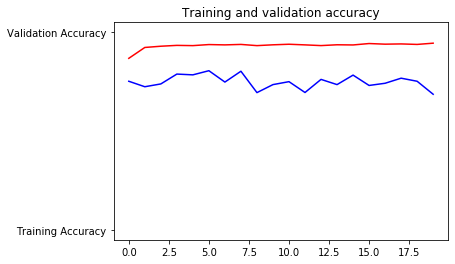

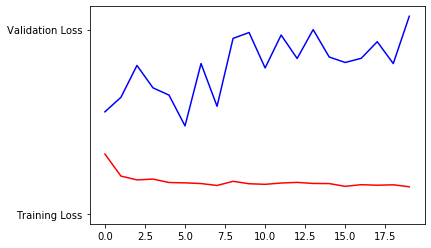

<Figure size 432x288 with 0 Axes>

In [12]:
%matplotlib inline
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()
plt.savefig('result.png')


In [13]:
model.layers[0].trainable = True

In [14]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers[0].layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[0].layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  708


In [15]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=0.0001/10),
              metrics=['accuracy'])

In [17]:
fine_tune_epochs = 10
total_epochs =  20 + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_generator)

Epoch 20/30


/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


349/349 [==============================] - 167s 478ms/step - loss: 0.5311 - accuracy: 0.9486 - val_loss: 0.4939 - val_accuracy: 0.9568
Epoch 21/30
349/349 [==============================] - 93s 267ms/step - loss: 0.5238 - accuracy: 0.9601 - val_loss: 0.5282 - val_accuracy: 0.9347
Epoch 22/30
349/349 [==============================] - 93s 267ms/step - loss: 0.5212 - accuracy: 0.9636 - val_loss: 0.5222 - val_accuracy: 0.9458
Epoch 23/30
349/349 [==============================] - 93s 267ms/step - loss: 0.5191 - accuracy: 0.9663 - val_loss: 0.4966 - val_accuracy: 0.9254
Epoch 24/30
349/349 [==============================] - 93s 266ms/step - loss: 0.5165 - accuracy: 0.9726 - val_loss: 0.5308 - val_accuracy: 0.9627
Epoch 25/30
349/349 [==============================] - 93s 266ms/step - loss: 0.5141 - accuracy: 0.9767 - val_loss: 0.5115 - val_accuracy: 0.9576
Epoch 26/30
349/349 [==============================] - 93s 265ms/step - loss: 0.5138 - accuracy: 0.9789 - val_loss: 0.5099 - val_accura

In [18]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

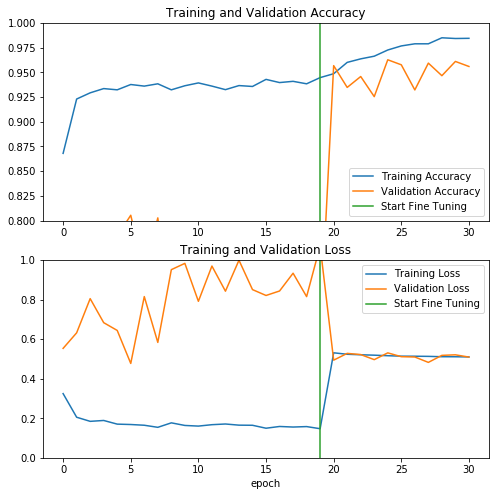

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([20-1,20-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([20-1,20-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy :', accuracy)

11/11 [==============================] - 8s 691ms/step
Test accuracy : 0.926948070526123


In [23]:
score=model.evaluate_generator(test_generator, 
                                   steps=11, 
                                   max_queue_size=10, 
                                   workers=1, #same with history
                                   use_multiprocessing=True, 
                                   verbose=1)

11/11 [==============================] - 6s 520ms/step


In [ ]:
new_model = tf.keras.models.load_model('/home/ec2-user/SageMaker/Image_Analytics/Data/model_dir/my_model')

In [ ]:
new_model.summary()

In [24]:
print('Test loss    :', score[0])
print('Test accuracy:', score[1])

Test loss    : 0.3782428205013275
Test accuracy: 0.926948070526123


In [25]:
#Print the Target names

target_names = []
for key in train_generator.class_indices:
    target_names.append(key)
print(target_names)

['neutral', 'porn']


In [26]:

Y_pred = model.predict_generator(test_generator, steps = 11) #steps (number of images * augmentation / batch_size
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
print(cm)
#     df_pred = pd.DataFrame({'Actual': test_generator, 'Predicted': Y_pred})
#     print(df_pred)

#Print Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))


Confusion Matrix
[[630   0]
 [602   0]]
Classification Report
              precision    recall  f1-score   support

     neutral       0.51      1.00      0.68       630
        porn       0.00      0.00      0.00       602

    accuracy                           0.51      1232
   macro avg       0.26      0.50      0.34      1232
weighted avg       0.26      0.51      0.35      1232



/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
#img='porn-43800.jpg'
img='01000.jpg'
test_image = load_img(img, target_size=(224, 224))
#test_image_array = np.array(test_image).reshape((1, 224, 224, 3)).tolist()
image = np.expand_dims(test_image, axis=0)

In [84]:
a=model.predict(image)
print(a)

[[1.6324615e-16]]


In [85]:
#image_batch, label_batch = test_generator.as_numpy_iterator().next()
predictions = model.predict(image)

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

# print('Predictions:\n', predictions.numpy())
# print('Labels:\n', label_batch)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(image_batch[i].astype("uint8"))
#     plt.title(class_names[predictions[i]])
#     plt.axis("off")
print(predictions)

tf.Tensor([[1]], shape=(1, 1), dtype=int32)


In [56]:
b=int(a)
print(b)

0


In [86]:
model.save('/home/ec2-user/SageMaker/Image_Analytics/Data/model_2/my_model')

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


In [87]:
from keras.models import model_from_json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [88]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [89]:
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(test_generator, verbose=0)

In [90]:
print(score)

[0.506719172000885, 0.926948070526123]


In [ ]:
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy :', accuracy)